In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LSTM, Input,SpatialDropout1D, GlobalMaxPool1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [2]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [3]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [4]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

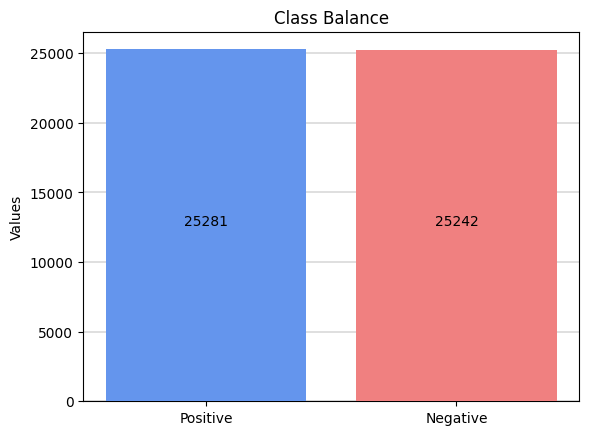

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vektorisasi teks menggunakan TF-IDF unigram(1,1)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,1), max_df=0.7, max_features=15000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [7]:
#Split data 70% data train and 30% data test
x_unigram = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unigram,label, test_size = 0.2)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(40418, 3445) (40418,)
(10105, 3445) (10105,)


In [8]:
y_train

39391    1
37639    0
6526     0
2082     1
21828    1
        ..
10170    1
22935    0
39230    1
36690    0
13301    1
Name: Label, Length: 40418, dtype: int64

In [9]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)

In [10]:
x_train

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [11]:
x_train.shape

(40418, 3445, 1)

In [12]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Membuat model cnn-lstm
def hybrid_cnn_lstm(x_train, y_train, x_test, y_test):


    model = Sequential()
    model.add(Input((x_train.shape[1], 1)))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=128,kernel_size=5,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(LSTM(128,return_sequences = True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")

    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))


    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d (SpatialDropout1D) │ (None, 3445, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1720, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,537 (27.38 MB)

 Trainable params: 7,177,537 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 113s 85ms/step - accuracy: 0.6848 - loss: 0.5368 - val_accuracy: 0.8048 - val_loss: 0.4063
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 129s 78ms/step - accuracy: 0.7639 - loss: 0.4194 - val_accuracy: 0.8260 - val_loss: 0.3650
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 144s 80ms/step - accuracy: 0.7831 - loss: 0.3881 - val_accuracy: 0.8240 - val_loss: 0.3646
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 140s 78ms/step - accuracy: 0.8003 - loss: 0.3576 - val_accuracy: 0.8280 - val_loss: 0.3676
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 99s 79ms/step - accuracy: 0.8089 - loss: 0.3325 - val_accuracy: 0.8277 - val_loss: 0.3835
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 141s 78ms/step - accuracy: 0.8219 - loss: 0.3141 - val_accuracy: 0.8260 - val_loss: 0.3733


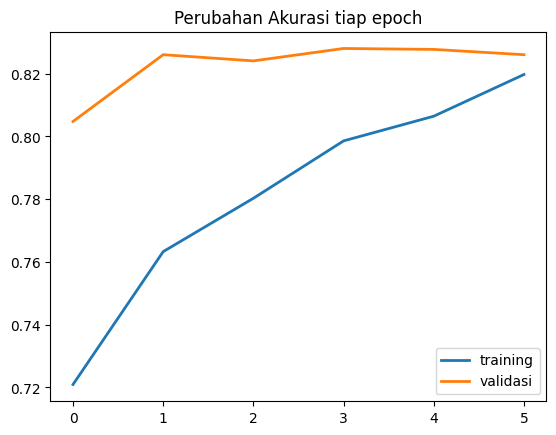

316/316 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.829360  0.825132  0.827241      5101
           1   0.822664  0.826938  0.824796      5004

    accuracy                       0.826027     10105
   macro avg   0.826012  0.826035  0.826018     10105
weighted avg   0.826044  0.826027  0.826030     10105



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1720, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,537 (27.38 MB)

 Trainable params: 7,177,537 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 102s 79ms/step - accuracy: 0.6906 - loss: 0.5347 - val_accuracy: 0.8014 - val_loss: 0.4028
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 141s 79ms/step - accuracy: 0.7596 - loss: 0.4256 - val_accuracy: 0.8240 - val_loss: 0.3669
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 142s 78ms/step - accuracy: 0.7812 - loss: 0.3920 - val_accuracy: 0.8325 - val_loss: 0.3593
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 100s 79ms/step - accuracy: 0.8035 - loss: 0.3565 - val_accuracy: 0.8259 - val_loss: 0.3628
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 100s 79ms/step - accuracy: 0.8168 - loss: 0.3256 - val_accuracy: 0.8222 - val_loss: 0.3686
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 141s 79ms/step - accuracy: 0.8212 - loss: 0.3148 - val_accuracy: 0.8248 - val_loss: 0.3737


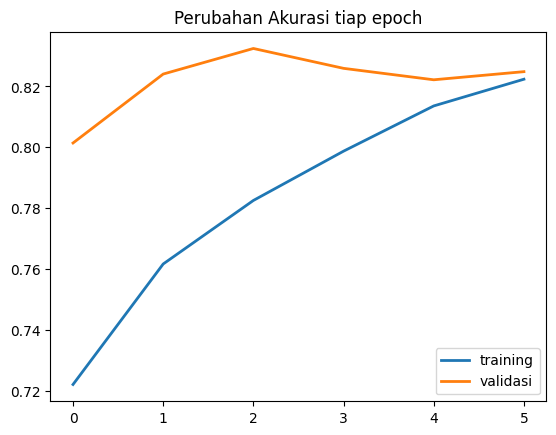

316/316 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.858095  0.782396  0.818499      5101
           1   0.796480  0.868106  0.830752      5004

    accuracy                       0.824839     10105
   macro avg   0.827287  0.825251  0.824625     10105
weighted avg   0.827583  0.824839  0.824566     10105



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1720, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,537 (27.38 MB)

 Trainable params: 7,177,537 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 102s 80ms/step - accuracy: 0.6968 - loss: 0.5281 - val_accuracy: 0.7896 - val_loss: 0.4297
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 141s 79ms/step - accuracy: 0.7624 - loss: 0.4298 - val_accuracy: 0.8177 - val_loss: 0.3668
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 142s 79ms/step - accuracy: 0.7807 - loss: 0.3856 - val_accuracy: 0.8285 - val_loss: 0.3567
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 102s 81ms/step - accuracy: 0.8032 - loss: 0.3543 - val_accuracy: 0.8287 - val_loss: 0.3789
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 147s 84ms/step - accuracy: 0.8141 - loss: 0.3332 - val_accuracy: 0.8263 - val_loss: 0.3691
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 140s 83ms/step - accuracy: 0.8223 - loss: 0.3128 - val_accuracy: 0.8251 - val_loss: 0.3801


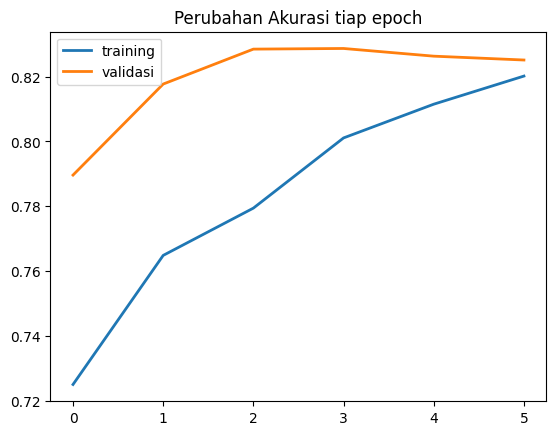

316/316 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.843995  0.801804  0.822359      5101
           1   0.807758  0.848921  0.827828      5004

    accuracy                       0.825136     10105
   macro avg   0.825877  0.825362  0.825093     10105
weighted avg   0.826051  0.825136  0.825067     10105



In [14]:
result = []
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))

In [15]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.8253339930727362
Average Precision : 0.8089672642637392
Average Recall    : 0.84798827604583
Average F1-Score  : 0.8277917976034606
